Duplicate key in file WindowsPath('C:/Users/tauyu/anaconda/lib/site-packages/matplotlib/mpl-data/matplotlibrc'), line 257 ('font.family:  IPAexGothic')


<IPython.core.display.Javascript object>


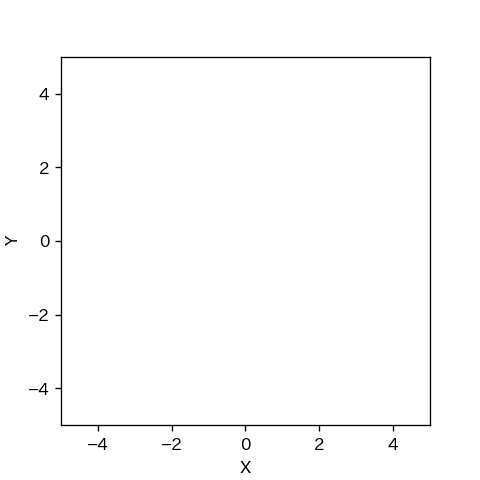

In [1]:
import sys
sys.path.append('../scripts/')
from mcl import *

In [2]:
class ResetMcl(Mcl): ###resetmcl3 （12行目以下）
    def __init__(self, envmap, init_pose, num, motion_noise_stds={"nn":0.19, "no":0.001, "on":0.13, "oo":0.2}, \
                 distance_dev_rate=0.14, direction_dev=0.05, alpha_threshold=0.001): #alpha_thresholdを追加
        super().__init__(envmap, init_pose, num, motion_noise_stds, distance_dev_rate, direction_dev)
        self.alpha_threshold = alpha_threshold #追加
        
    def random_reset(self):
         for p in self.particles:
                p.pose = np.array([np.random.uniform(-5.0, 5.0), np.random.uniform(-5.0, 5.0), np.random.uniform(-math.pi, math.pi)]).T
                p.weight = 1/len(self.particles)
                
    def sensor_resetting_draw(self, particle, landmark_pos, ell_obs, phi_obs): #追加
            ##パーティクルの位置を決める##
            psi = np.random.uniform(-np.pi, np.pi) #ランドマークからの方角を選ぶ
            ell = norm(loc=ell_obs, scale=(ell_obs*self.distance_dev_rate)**2).rvs() #ランドマークからの距離を選ぶ
            particle.pose[0] = landmark_pos[0] + ell*math.cos(psi)
            particle.pose[1] = landmark_pos[1] + ell*math.sin(psi)
            
            ##パーティクルの向きを決める##
            phi = norm(loc=phi_obs, scale=(self.direction_dev)**2).rvs() #ランドマークが見える向きを決める
            particle.pose[2] = math.atan2(landmark_pos[1]- particle.pose[1], landmark_pos[0]- particle.pose[0]) - phi
            
            particle.weight = 1.0/len(self.particles) #重みを1/Nに
            
    def sensor_resetting(self, observation): #追加
        nearest_obs = np.argmin([obs[0][0] for obs in observation]) #距離が一番近いランドマークを選択
        values, landmark_id = observation[nearest_obs]
        
        for p in self.particles:
            self.sensor_resetting_draw(p, self.map.landmarks[landmark_id].pos, *values)
        
    def observation_update(self, observation):        
        for p in self.particles:
            p.observation_update(observation, self.map, self.distance_dev_rate, self.direction_dev) 
            
        self.set_ml()

        if sum([p.weight for p in self.particles]) < self.alpha_threshold: 
            self.sensor_resetting(observation) #sensor_resettingに変更
        else:
            self.resampling() 

In [3]:
def trial_kidnap(animation): ###mclkidnap1test
    time_interval = 0.1
    world = World(30, time_interval, debug=not animation) 

    ## 地図を生成して3つランドマークを追加 ##
    m = Map()
    m.append_landmark(Landmark(-2,-2))
    m.append_landmark(Landmark(2,-2))
    m.append_landmark(Landmark(0,2*math.sqrt(3)-2))
    world.append(m)

    ## ロボットを作る ##
    init_pose = np.array([np.random.uniform(-5.0, 5.0), np.random.uniform(-5.0, 5.0), np.random.uniform(-math.pi, math.pi)]).T
    robot_pose = np.array([np.random.uniform(-4.0, -2.0), np.random.uniform(-4.0, 4.0), np.random.uniform(-math.pi, math.pi)]).T
    pf = ResetMcl(m, init_pose, 100)
    a = EstimationAgent(time_interval, 0.2, 10.0/180*math.pi, pf)
    r = Robot(robot_pose, sensor=Camera(m), agent=a, color="red")
    world.append(r)

    world.draw()
    
    return (r.pose, pf.ml.pose)

C:\Users\tauyu\anaconda\lib\site-packages\matplotlib\animation.py:889: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you have outputted the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


<IPython.core.display.Javascript object>


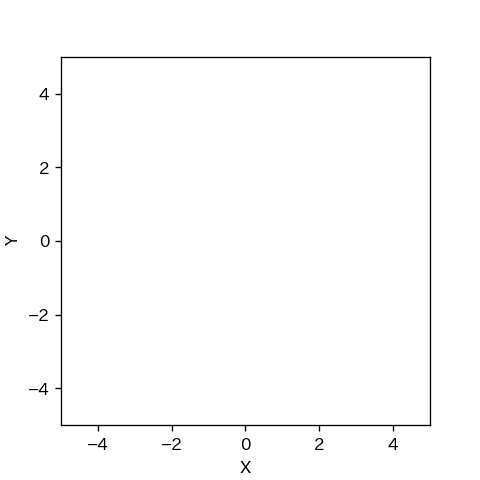

(array([-2.73448913, -1.54516168,  2.33914095]),
 array([-4.39333372,  1.57253549,  1.80741724]))

In [4]:
trial_kidnap(True)

In [5]:
if __name__ =='__main__':
    ok=0
    for i in range(1000):
        actual, estm=trial_kidnap(False)
        diff=math.sqrt((actual[0]-estm[0])**2+(actual[1]-estm[1])**2)
        print(i,"真値:",actual,"推定値:",estm,"誤差:",diff)
        if diff<=1.0:
            ok+=1
            print(ok)

0 真値: [-1.76305612 -0.68986636  3.25378644] 推定値: [-1.90237627 -0.08811448  3.1093951 ] 誤差: 0.6176693485536509
1
1 真値: [-2.30251573 -1.1092066   7.1124672 ] 推定値: [-2.11548539 -1.12942879  0.87077804] 誤差: 0.18812039965404775
2
2 真値: [-0.41525876  3.35755609  2.09832488] 推定値: [-0.50383922  3.18253196  2.38655055] 誤差: 0.19616305207997947
3
3 真値: [-2.10427079  1.419723    7.74715174] 推定値: [-1.88138583  1.52120527  1.3908582 ] 誤差: 0.2449007057605025
4
4 真値: [-4.69225906 -2.3696337   6.36322397] 推定値: [-4.03235427 -0.58520518 -0.77576805] 誤差: 1.9025402717147735
5 真値: [-2.33022787 -0.21042766  2.4133119 ] 推定値: [-2.11739544  0.06770446  2.5493314 ] 誤差: 0.35022153310071874
5
6 真値: [-2.29057049  0.5117007   8.6074981 ] 推定値: [-2.17814512  0.08795933  2.23051163] 誤差: 0.4384018770174113
6
7 真値: [-2.66288719 -2.55079912  2.59499205] 推定値: [-2.55987917 -2.40508069  2.60481474] 誤差: 0.17845030897836917
7
8 真値: [-4.9201393  -5.19311283  6.49164802] 推定値: [ 1.644853   -3.97658536  2.09103988] 誤差: 6.676755421

C:\Users\tauyu\section_advanced_localization\../scripts\ideal_robot.py:30: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(4,4))


20 真値: [-2.87140115 -2.21669653  5.33227968] 推定値: [-2.99795918 -2.61053614  5.39688539] 誤差: 0.41367448219398345
18
21 真値: [-3.81668223  2.22629289  5.59241489] 推定値: [-4.44290177  1.95510476 -0.58964708] 誤差: 0.6824176949152683
19
22 真値: [-4.16183545  4.25988325  5.1552242 ] 推定値: [-3.69103497  1.92862537  5.63241189] 誤差: 2.378322189135122
23 真値: [-2.32436164 -0.24914367  2.90240591] 推定値: [-2.50717979 -0.53723762  2.74132059] 誤差: 0.341204628989691
20
24 真値: [-2.87412282  2.88174227  3.84460787] 推定値: [-3.36594363  2.27887795  3.88428752] 誤差: 0.7780315527847553
21
25 真値: [-3.45942956  4.1807274   4.97618582] 推定値: [-3.39329901  4.16959568  5.01252442] 誤差: 0.06706089896272636
22
26 真値: [-1.40632647  0.33862203  3.24354765] 推定値: [-1.43165219  0.51300301  2.94488872] 誤差: 0.17621044472189426
23
27 真値: [-4.45113999 -2.17437251  5.92745621] 推定値: [-3.81030824 -2.11700322  5.94973338] 誤差: 0.6433945645573791
24
28 真値: [-4.18702484 -3.70845796  6.81146755] 推定値: [-3.80002726 -4.28979184  6.98706868] 誤差